In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics

import numpy as np
import pandas as pd

In [2]:
import mlflow
from mlflow.models import infer_signature

import os 
import seaborn as sns
from tqdm.notebook import tqdm

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LOOKBACK = 5
HORIZON = 1

LEARNING_RATE = 0.1
BATCH_SIZE = 6
NUM_EPOCHS = 4000
LR_DECAY = 0.1
PATIENCE = 5

HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0

In [4]:
sns.set_theme('paper', rc={'figure.figsize': (16, 4)})

torch.manual_seed(42)

mlflow.set_experiment("Stock Market Predictions")
mlflow.start_run(run_name="LSTM")

<ActiveRun: >

In [5]:
df = pd.read_csv('../data/SSEC.csv', index_col='Date')
data = df['Close'].values

mlflow.log_param("Dataset", "SSEC")

'SSEC'

In [6]:
train_size = int(0.7 * len(data))
val_size = int(0.15 * len(data))
test_size = len(data) - train_size - val_size

data_train, data_val, data_test = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

In [7]:
data_train.shape, data_val.shape, data_test.shape

((2382,), (510,), (511,))

In [8]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))

data_train = torch.FloatTensor(scaler.fit_transform(data_train.reshape(-1, 1))).to(DEVICE)
data_val = torch.FloatTensor(scaler.transform(data_val.reshape(-1, 1))).to(DEVICE)
data_test = torch.FloatTensor(scaler.transform(data_test.reshape(-1, 1))).to(DEVICE)

In [9]:
data_train.size(), data_val.size(), data_test.size()

(torch.Size([2382, 1]), torch.Size([510, 1]), torch.Size([511, 1]))

In [10]:
X_train = data_train.unfold(dimension=0, size=LOOKBACK, step=1)[:-1]
y_train = data_train[LOOKBACK:]

X_val = data_val.unfold(dimension=0, size=LOOKBACK, step=1)[:-1]
y_val = data_val[LOOKBACK:]

X_test = data_test.unfold(dimension=0, size=LOOKBACK, step=1)[:-1]
y_test = data_test[LOOKBACK:]

In [11]:
# (N,L,H_in​) 
X_train.size(), y_train.size(), X_val.size(), y_val.size(), X_test.size(), y_test.size()

(torch.Size([2377, 1, 5]),
 torch.Size([2377, 1]),
 torch.Size([505, 1, 5]),
 torch.Size([505, 1]),
 torch.Size([506, 1, 5]),
 torch.Size([506, 1]))

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=1, num_layers=1, output_size=1, dropout=0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [13]:
model = LSTMModel(LOOKBACK, HIDDEN_SIZE, NUM_LAYERS, HORIZON, DROPOUT)
criterion = nn.MSELoss()

model.to(DEVICE)
criterion.to(DEVICE)

optimizer = optim.SGD(model.parameters(),lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=LR_DECAY, patience=PATIENCE)

In [14]:
params = {
    "Lookback": LOOKBACK,
    "Horizon": HORIZON,
    "Objective": type(criterion).__name__,
    "Optimizer": type(optimizer).__name__,
    "Scaler": type(scaler).__name__,
    "Scheduler": type(scheduler).__name__,
    "Num epochs": NUM_EPOCHS,
    "Batch size": BATCH_SIZE,
    "Learning rate": LEARNING_RATE,
    "Patience": PATIENCE,
    "LR Decay": LR_DECAY,  
    "Input size": LOOKBACK,
    "Hidden size": HIDDEN_SIZE,
    "Num layers": NUM_LAYERS,
    "Dropout": DROPOUT
}

mlflow.log_params(params)

In [15]:
def train(model: torch.nn.Module, X_train: torch.Tensor, y_train: torch.Tensor, X_val: torch.Tensor, y_val: torch.Tensor, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler._LRScheduler, num_epochs: int):
    best_val_loss = torch.Tensor([float('inf')]).to(X_train.device)
    trigger_times = 0
    train_losses = []
    val_losses = []

    for epoch in (pbar:=tqdm(range(num_epochs), unit="epoch")):
        
        model.train()
        output = model(X_train)
        
        loss = criterion(output, y_train)
        loss.backward()
                    
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step(loss)
        
        train_losses.append(loss.item())
        pbar.set_description(f"Epoch: {epoch+1}, current training loss: {loss:.4f}", refresh=True)
        mlflow.log_metric("train loss", loss.item(), step=epoch+1)

        if (epoch+1) % (num_epochs/100) == 0:
            with torch.no_grad():
                
                model.eval()
                output = model(X_val)
                val_loss = criterion(output, y_val)
                
                val_losses.append(val_loss.item())
                pbar.set_postfix({"last validation loss": val_loss.item(), "best validation loss": best_val_loss.item()}, refresh=True)
                mlflow.log_metric("val loss", val_loss.item(), step=epoch+1)
                
                # Early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    trigger_times = 0 
                    
                    mlflow.log_metric("best val loss", best_val_loss.item())                 
                    torch.save(model.state_dict(), f'../models/{type(model).__name__}.pt')
                    
                else:
                    trigger_times += 1
                    if trigger_times >= PATIENCE:
                        print(f"Early stopping at epoch {epoch+1}")
                        mlflow.log_metric("early stop epoch", epoch+1)
                        break

    return train_losses, val_losses

In [16]:
train_losses, val_losses = train(model, X_train, y_train, X_val, y_val, criterion, optimizer, scheduler, NUM_EPOCHS)

  0%|          | 0/4000 [00:00<?, ?epoch/s]

Early stopping at epoch 2840


<Axes: >

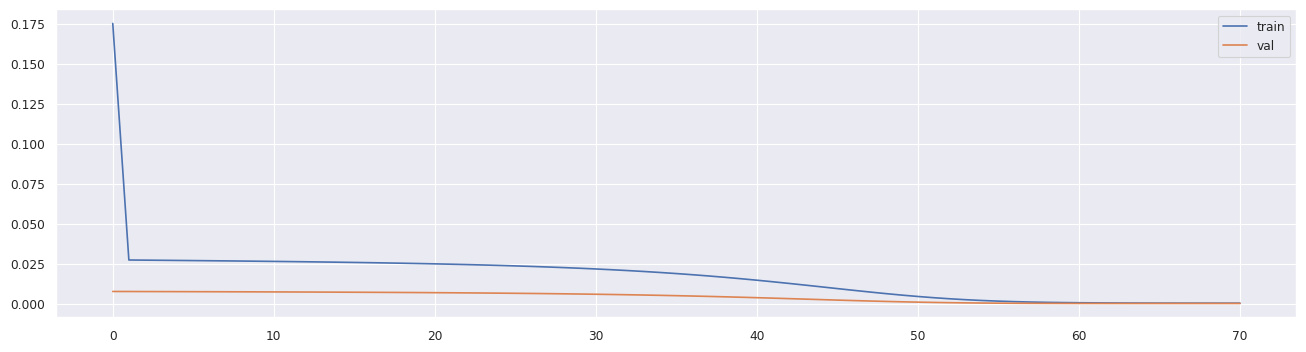

In [17]:
sns.lineplot(data=pd.DataFrame(data={'train': train_losses[::len(train_losses)//len(val_losses)], 'val': val_losses}), dashes=False)

Registered model 'LSTM' already exists. Creating a new version of this model...
2025/02/24 11:01:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM, version 15
Created version '15' of model 'LSTM'.


<Axes: xlabel='Date'>

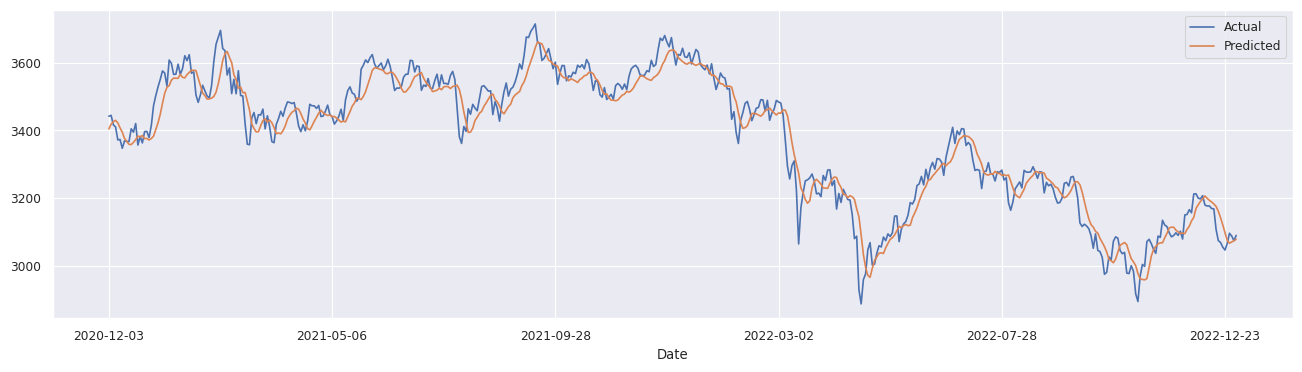

In [18]:
if os.path.exists(f'../models/{type(model).__name__}.pt'):    
    model.load_state_dict(torch.load(f"../models/{type(model).__name__}.pt"))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

y_pred_inv = scaler.inverse_transform(y_pred.cpu().detach().numpy()).flatten()
y_test_inv = scaler.inverse_transform(y_test.cpu().detach().numpy()).flatten()

mlflow.pytorch.log_model(
    registered_model_name="LSTM",
    artifact_path="LSTM",
    pytorch_model=model,
    input_example = X_test.cpu().detach().numpy(),
    signature=infer_signature(X_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
)

pd.DataFrame([y_test_inv, y_pred_inv], index=['Actual', 'Predicted'], columns=df.index[-len(X_test):]).T.plot()

In [19]:
# Calculate MAE, MSE, and RMSE
mae = metrics.mean_absolute_error(y_pred_inv, y_test_inv)
mse = metrics.mean_squared_error(y_pred_inv, y_test_inv)
rmse = metrics.mean_squared_error(y_pred_inv, y_test_inv) ** 0.5

# Log the metrics to mlflow
mlflow.log_metric("Test MAE", mae)
mlflow.log_metric("Test MSE", mse)
mlflow.log_metric("Test RMSE", rmse)

print(f"MAE: {mae:.4f}  MSE: {mse:.4f} RMSE: {rmse:.4f}")

MAE: 37.9984  MSE: 2457.6101 RMSE: 49.5743


<Axes: xlabel='Date'>

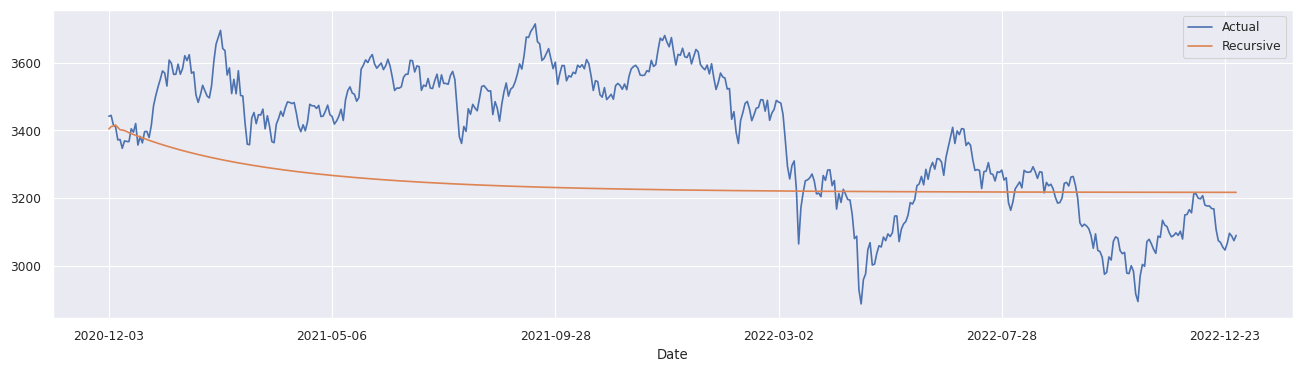

In [20]:
model.eval()
y_recursive = []

# Start with the first element of X_test
current_input = X_test[0].unsqueeze(0)

with torch.no_grad():
    for _ in range(len(X_test)):
        output = model(current_input).unsqueeze(0)
        y_recursive.append(output.cpu().numpy())

        # Prepare the next input by appending the prediction to the current input and removing the oldest value
        current_input = torch.cat((current_input[:, :, 1:], output), dim=2)

y_recursive = np.concatenate(y_recursive, axis=1).squeeze()
y_recursive_inv = scaler.inverse_transform(y_recursive.reshape(-1, 1)).flatten()

pd.DataFrame([y_test_inv, y_recursive_inv], index=['Actual', 'Recursive'], columns=df.index[-len(X_test):]).T.plot()

In [21]:
# Calculate MAE, MSE, and RMSE
mae = metrics.mean_absolute_error(y_recursive_inv, y_test_inv)
mse = metrics.mean_squared_error(y_recursive_inv, y_test_inv)
rmse = metrics.mean_squared_error(y_recursive_inv, y_test_inv) ** 0.5

# Log the metrics to mlflow
mlflow.log_metric("Recursive Test MAE", mae)
mlflow.log_metric("Recursive Test MSE", mse)
mlflow.log_metric("Recursive Test RMSE", rmse)
mlflow.end_run()

print(f"Recursive MAE: {mae:.4f} Recursive MSE: {mse:.4f} Recursive RMSE: {rmse:.4f}")

🏃 View run LSTM at: http://172.18.0.2:5000/#/experiments/689077898730888678/runs/13c89b8087ff4e7893ea4f02600a7359
🧪 View experiment at: http://172.18.0.2:5000/#/experiments/689077898730888678
Recursive MAE: 195.6312 Recursive MSE: 53465.9805 Recursive RMSE: 231.2271


<Axes: xlabel='Date'>

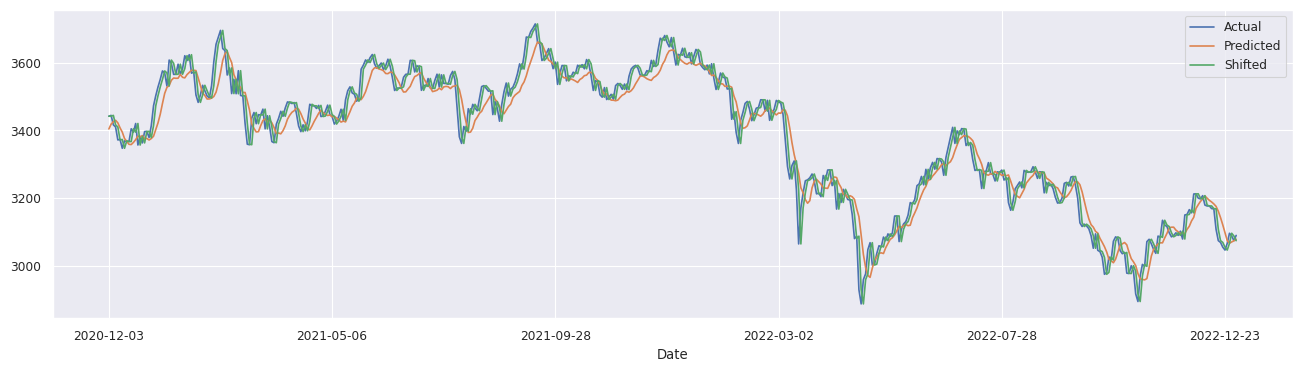

In [22]:
#Compare to the naive forecast
shifted_y_test_inv = np.roll(y_test_inv, 1).flatten()
shifted_y_test_inv[0] = y_test_inv[0]

pd.DataFrame([y_test_inv, y_pred_inv, shifted_y_test_inv], index=['Actual', 'Predicted', 'Shifted'], columns=df.index[-len(X_test):]).T.plot()

In [23]:
# Naive predictions
mae = metrics.mean_absolute_error(shifted_y_test_inv, y_test_inv)
mse = metrics.mean_squared_error(shifted_y_test_inv, y_test_inv)
rmse = metrics.mean_squared_error(shifted_y_test_inv, y_test_inv) ** 0.5

print(f"MAE: {mae:.4f}  MSE: {mse:.4f} RMSE: {rmse:.4f}")

MAE: 24.9891  MSE: 1112.6173 RMSE: 33.3559


In [24]:
const_pred_inv = np.full_like(y_test_inv.flatten(), scaler.inverse_transform(X_test[0].cpu().numpy().flatten().reshape(-1, 1))[-1][0])

<Axes: xlabel='Date'>

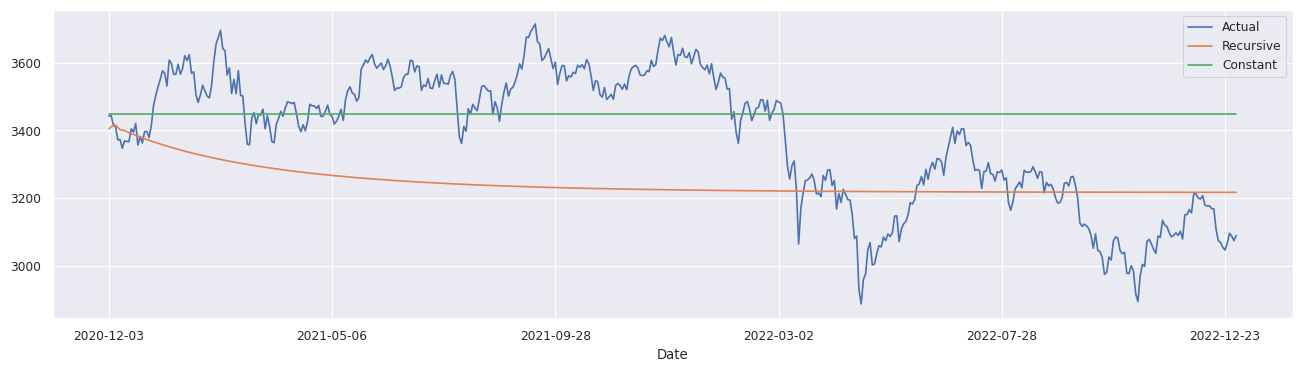

In [25]:
pd.DataFrame([y_test_inv, y_recursive_inv, const_pred_inv], index=['Actual', 'Recursive', 'Constant'], columns=df.index[-len(X_test):]).T.plot()

In [26]:
# Constant prediction
mae = metrics.mean_absolute_error(const_pred_inv, y_test_inv)
mse = metrics.mean_squared_error(const_pred_inv, y_test_inv)
rmse = metrics.mean_squared_error(const_pred_inv, y_test_inv) ** 0.5

print(f"Recursive MAE: {mae:.4f} Recursive MSE: {mse:.4f} Recursive RMSE: {rmse:.4f}")

Recursive MAE: 165.6979 Recursive MSE: 42911.6953 Recursive RMSE: 207.1514


<Axes: xlabel='Date'>

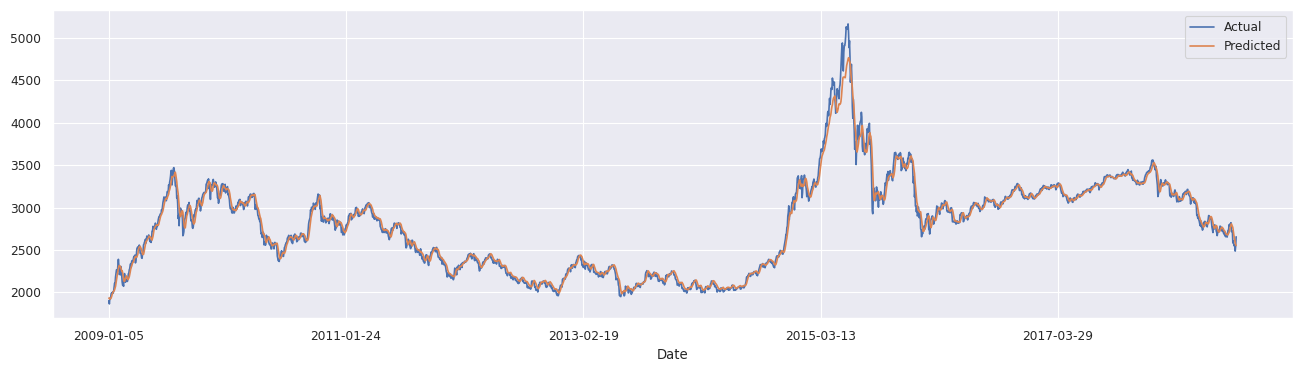

In [27]:
# Get predictions on the training dataset to check for overfitting
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)

y_train_pred_inv = scaler.inverse_transform(y_train_pred.cpu().detach().numpy()).flatten()
y_train_inv = scaler.inverse_transform(y_train.cpu().detach().numpy()).flatten()

pd.DataFrame([y_train_inv, y_train_pred_inv], index=['Actual', 'Predicted'], columns=df.index[:len(X_train)]).T.plot()

In [28]:
# Evaluate the model on the training dataset
mae = metrics.mean_absolute_error(y_train_pred_inv, y_train_inv)
mse = metrics.mean_squared_error(y_train_pred_inv, y_train_inv)
rmse = metrics.mean_squared_error(y_train_pred_inv, y_train_inv) ** 0.5

print(f"Train MAE: {mae:.4f} Train MSE: {mse:.4f} Train RMSE: {rmse:.4f}")

Train MAE: 48.2853 Train MSE: 5582.4829 Train RMSE: 74.7160
